In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src.plotsiii import plotiii1, plotiii2
from src.plotsv import plotv

ImportError: cannot import name 'plotv' from 'src.plotsv' (/Users/maxtalberg/Documents/Max/Cambridge2324/Lent/Statistics/Coursework/src/plotsv.py)

In [3]:
# set seed
np.random.seed(120420)

### Tensorflow HMC 

In [4]:
from corner import corner
import tensorflow as tf
import tensorflow_probability as tfp

tdf = tfp.distributions

In [6]:
# read text file
file_path = 'src/lighthouse_flash_data.txt'

first_column_data = []

with open(file_path, 'r') as file:
    # Iterate over each line in the file
    for line in file:
        # Split the line into columns using the comma as a delimiter
        columns = line.strip().split(' ')
        # Append the first column value to your list
        first_column_data.append(columns[0])

first_column_data = np.array(first_column_data, dtype=np.float64)
# Now first_column_data contains all the values from the first column
print(first_column_data)


[  5.45077359   2.88307026   0.38873515  -1.10860014   1.10935762
  -2.62856487  -1.78031276  70.52898471  -0.18206971  -0.86582179
   2.3751604    0.48651618  -2.21155541   0.9728888   -4.71733272
  -1.27137259 -18.87369737  -1.29333594  -0.66104092  13.56432676]


In [25]:
# set seed
np.random.seed(120420)
tf.random.set_seed(120420)

# Read the data
def read_data(file_path):
    '''
    Function to read data from a text file and return it as two lists.
    '''
    # initialise lists to store the data
    column1 = []  
    column2 = []  
    
    with open(file_path, 'r') as file:  # Open the file for reading
        for line in file:  # Iterate over each line in the file
            parts = line.split()  # Split the line by whitespace
            
            # Append the parts to their respective column lists
            column1.append(float(parts[0]))
            column2.append(float(parts[1]))

    return column1, column2

# Set the parameters
# observed flashes
x_observed = np.array(read_data(file_path)[0])


In [13]:
# set seed
np.random.seed(120420)
tf.random.set_seed(120420)

# observed flashes
x_observed = first_column_data

# constants for the uniform prior
a = -10
b = 10
c = 10

# joint log probability function
def joint_log_prob(x, alpha, beta):
    # likelihood
    likelihood = tdf.Cauchy(loc=alpha, scale=beta).log_prob(x)
    log_likelihood = tf.reduce_sum(likelihood)

    # prior
    log_prior_alpha = tf.where(
        tf.logical_and(alpha > a, alpha < b),
        tf.math.log(1/(b-a)),
        -np.inf
    
    )
    log_prior_beta = tf.where(
        tf.logical_and(beta > 0, beta < c),
        tf.math.log(1/c),
        -np.inf
    )

    return log_prior_alpha + log_prior_beta + log_likelihood

# Define the unnormalized posterior
def unnormalized_posterior(alpha, beta):
    return joint_log_prob(x_observed, alpha, beta)

In [14]:
# hmc kernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior,
  step_size=np.float64(.01),
  num_leapfrog_steps=200) # 200

'''# Adpative step size
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  hmc_kernel,
  num_adaptation_steps=int())
'''
# run hmc
@tf.function
def run_chain(num_results=30000, num_burnin_steps=3000):
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[np.mean(x_observed), 1.0],
      kernel=hmc_kernel,
      trace_fn=lambda _, pkr: pkr.is_accepted
      )
  return samples, kernel_results

samples, kernel_results = run_chain()
alpha_samples, beta_samples = samples

In [17]:
# mean and std of alpha and beta
mean_alpha = np.mean(alpha_samples)
std_alpha = np.std(alpha_samples)

mean_beta = np.mean(beta_samples)
std_beta = np.std(beta_samples)

print('alpha:', mean_alpha, std_alpha)
print('beta:', mean_beta, std_beta)

alpha: -0.4481178 0.6121482
beta: 1.9684646 0.6642829


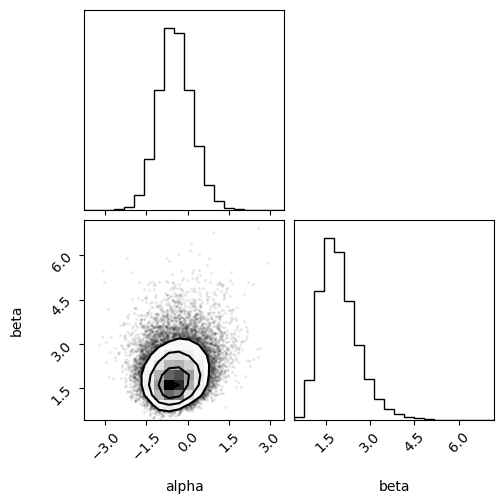

In [18]:
samples_np = np.column_stack([tensor.numpy() for tensor in samples])
corner(samples_np, labels=['alpha', 'beta'])
plt.show()

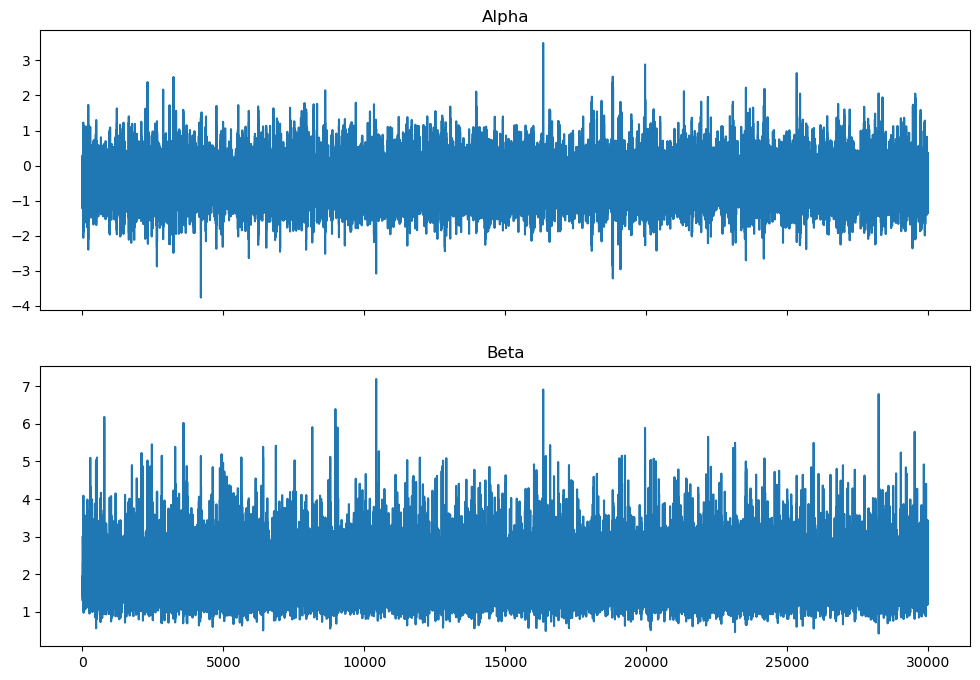

In [19]:
# plot alpha and beta samples
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
axes[0].plot(alpha_samples)
axes[0].title.set_text('Alpha')
axes[1].plot(beta_samples)
axes[1].title.set_text('Beta')
plt.show()


In [20]:
# version of tensorflow
print(tf.__version__)


2.12.0


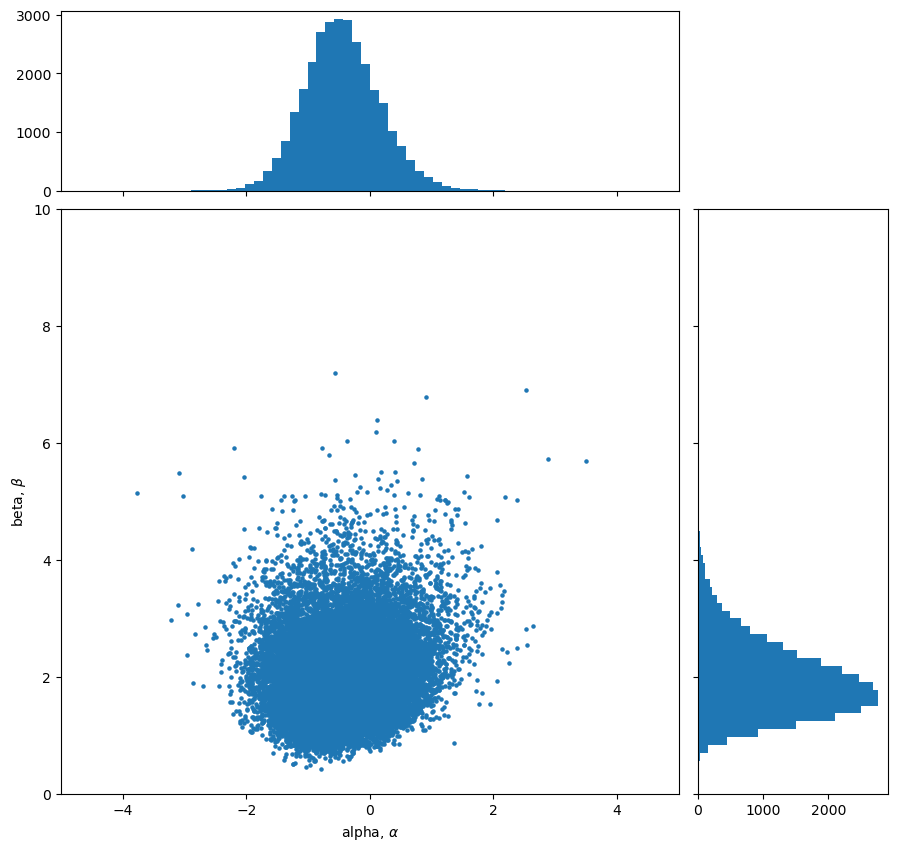

In [40]:
from matplotlib.ticker import NullFormatter

x,y = samples

nullfmt = NullFormatter() 

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# i 2d histogram
fig = plt.figure(1, figsize=(9.5,9))

# plot
axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(x, y, s=5)

# Set the axis labels
axScatter.set_xlabel(r'alpha, $\alpha$')
axScatter.set_ylabel(r'beta, $\beta$')

# now determine nice limits by hand:
binwidth = 0.25
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-5, 5))
axScatter.set_ylim((-0, 10))

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=50)
axHisty.hist(y, bins=50, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())


plt.show()

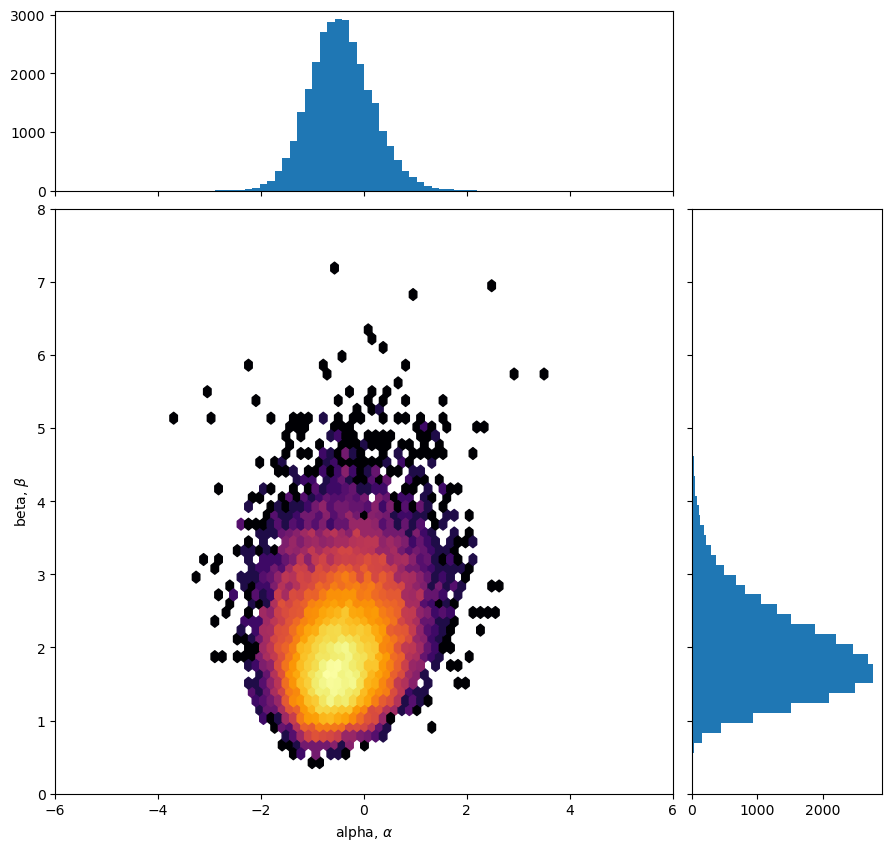

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

# Sample data - replace this with your actual data
x, y = samples

nullfmt = NullFormatter()

# Definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# Start figure
fig = plt.figure(figsize=(9.5, 9))

# Scatter plot
axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# No labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# Create a hexbin plot with a color bar
hb = axScatter.hexbin(x, y, gridsize=50, cmap='inferno', bins='log')

# Set axis labels
axScatter.set_xlabel(r'alpha, $\alpha$')
axScatter.set_ylabel(r'beta, $\beta$') 

# Determine nice limits by hand
binwidth = 0.25
xymax = np.max([np.max(np.abs(x)), np.max(np.abs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-6, 6))
axScatter.set_ylim((0, 8))

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=50)
axHisty.hist(y, bins=50, orientation='horizontal')

# Set limits for the histograms
axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()
